In [1]:
import os
# import colabdesign
# from colabdesign.mpnn import mk_mpnn_model, clear_mem
# from colabdesign.shared.protein import pdb_to_string
os.chdir('/home/jupyter-yehlin')
import os
# import colabdesign
# from colabdesign.mpnn import mk_mpnn_model, clear_mem
# from colabdesign.shared.protein import pdb_to_string
os.chdir('/home/jupyter-yehlin/DMSV2/')
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import tqdm.notebook
import seaborn
import re, tempfile
# from colabdesign.af.contrib import predictz
# from colabdesign.shared.protein import _np_rmsd

if "hhsuite" not in os.environ['PATH']:
    os.environ['PATH'] += ":/home/jupyter-yehlinMSV2/"
    
    
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pearsonr
import shutil
import random


/tmp/ipykernel_1151030/1126341549.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [298]:
def parse_PDB_biounits(x, atoms=["N", "CA", "C", "O", "CB", "CG", "CD1", "CD2", "CE2", "CE3", "NE1", "CZ2", "CZ3", "CH2"], chain='A'):
  '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, atoms, coords=(x,y,z)), sequence
  '''

  alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
  states = len(alpha_1)
  alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
             'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','GAP']
  
  aa_1_N = {a:n for n,a in enumerate(alpha_1)}
  aa_3_N = {a:n for n,a in enumerate(alpha_3)}
  aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
  aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
  aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}
  
  def AA_to_N(x):
    # ["ARND"] -> [[0,1,2,3]]
    x = np.array(x);
    if x.ndim == 0: x = x[None]
    return [[aa_1_N.get(a, states-1) for a in y] for y in x]
  
  def N_to_AA(x):
    # [[0,1,2,3]] -> ["ARND"]
    x = np.array(x);
    if x.ndim == 1: x = x[None]
    return ["".join([aa_N_1.get(a,"-") for a in y]) for y in x]

  xyz,seq,min_resn,max_resn = {},{},1e6,-1e6
  for line in open(x,"rb"):
    line = line.decode("utf-8","ignore").rstrip()

    if line[:6] == "HETATM" and line[17:17+3] == "MSE":
      line = line.replace("HETATM","ATOM  ")
      line = line.replace("MSE","MET")

    if line[:4] == "ATOM":
      ch = line[21:22]
      if ch == chain or chain is None:
        atom = line[12:12+4].strip()
        resi = line[17:17+3]
        resn = line[22:22+5].strip()
        x,y,z = [float(line[i:(i+8)]) for i in [30,38,46]]

        if resn[-1].isalpha(): 
            resa,resn = resn[-1],int(resn[:-1])-1
        else: 
            resa,resn = "",int(resn)-1
#         resn = int(resn)
        if resn < min_resn: 
            min_resn = resn
        if resn > max_resn: 
            max_resn = resn
        if resn not in xyz: 
            xyz[resn] = {}
        if resa not in xyz[resn]: 
            xyz[resn][resa] = {}
        if resn not in seq: 
            seq[resn] = {}
        if resa not in seq[resn]: 
            seq[resn][resa] = resi

        if atom not in xyz[resn][resa]:
          xyz[resn][resa][atom] = np.array([x,y,z])

  # convert to numpy arrays, fill in missing values
  seq_,xyz_ = [],[]
  try:
      for resn in range(min_resn,max_resn+1):
        if resn in seq:
          for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k],20))
        else: seq_.append(20)
        if resn in xyz:
          for k in sorted(xyz[resn]):
            for atom in atoms:
              if atom in xyz[resn][k]: xyz_.append(xyz[resn][k][atom])
              else: xyz_.append(np.full(3,np.nan))
        else:
          for atom in atoms: xyz_.append(np.full(3,np.nan))
      return np.array(xyz_).reshape(-1,len(atoms),3), N_to_AA(np.array(seq_))
  except TypeError:
      return 'no_chain', 'no_chain'



In [299]:
order = "ACDEFGHIKLMNPQRSTVWYX"
amino_acid_to_number = {aa: i for i, aa in enumerate(order)}

def get_pairs_single(S, contact_pairwise_index):
    index_1 = contact_pairwise_index[:, 0].astype(np.int64)
    index_2 = contact_pairwise_index[:, 1].astype(np.int64)
    

    
    wt_1 = S[index_1]

    wt_2 = S[index_2]

    wt_pairwise = (wt_1 * 21) + wt_2
    
    true_pairwise = wt_pairwise.flatten()

    true_pairwise_count = np.bincount(true_pairwise).astype(int)

    return true_pairwise_count

def calculate_contacts_and_get_pairwise(xyz, seq, distance_threshold=3, pairwise_threshold=6):

    dict_coord = {}  # dict to store coordinates. dict_coord[res][atom] = (x, y, z)
    contacting_pairs = []  # List to store pairs of contacting residues as [ires, jres]

    # Precompute distance threshold squared
    distance_threshold_sq = distance_threshold ** 2

    for i, (xyz, res) in enumerate(zip(xyz, seq)):
        for atom_num, coords in enumerate(xyz):
            if not np.isnan(coords).any():  # Skip atoms with NaN coordinates
                x, y, z = coords
                res = i + 1  # Numeric index for the residue
                if res not in dict_coord:
                    dict_coord[res] = []
                dict_coord[res].append((x, y, z))

    res_list = list(dict_coord.keys())
    res_coords = [np.array(dict_coord[res]) for res in res_list]

    for i, ires_coords in enumerate(res_coords):
        for j in range(i + 1, len(res_list)):
            jres_coords = res_coords[j]
            distances = np.sum((ires_coords[:, np.newaxis] - jres_coords) ** 2, axis=-1)
            close_atoms = np.argwhere(distances < distance_threshold_sq)
            if close_atoms.size > 0 and abs(i-j)>=6:
                contacting_pairs.append([res_list[i]-1, res_list[j]-1])
                
                
    S = np.array([amino_acid_to_number[aa] for aa in seq])
    contacting_pairs= np.array(contacting_pairs)
    test_true_pairs = np.zeros(441, dtype=int)
    true_pairwise_count = get_pairs_single(S, contacting_pairs)
    test_true_pairs[:len(true_pairwise_count)] += true_pairwise_count

    return test_true_pairs, contacting_pairs



In [300]:
xyz,seq  = parse_PDB_biounits('dataset/af2_predicted/r9_1085_TrROS_Hall_unrelaxed_model_1.pdb')
a, contacting_pairs=calculate_contacts_and_get_pairwise(xyz, seq[0])

In [301]:
contacting_pairs

array([[ 0, 59],
       [ 1, 21],
       [ 1, 38],
       [ 2, 57],
       [ 2, 62],
       [ 3, 19],
       [ 4, 55],
       [ 5, 17],
       [ 6, 52],
       [ 6, 53],
       [ 7, 15],
       [21, 38]])

## pairwise analysis within 5A

In [3]:
import re
import ast
import pandas as pd

# Function to add commas to the list-like string and convert it to a list
def fix_list_str(input_str):
    # Add commas between numbers
    fixed_str = re.sub(r'(\d+)', r'\1, ', input_str)
    # Add brackets and convert to a list
    return ast.literal_eval(f"[{fixed_str}]")

# Read CSV file
df = pd.read_csv('pairwise_counts_combined.csv')

# Apply the custom function to the 'pairwise_count' column
df['pairwise_count'] = df['pairwise_count'].apply(fix_list_str)

In [4]:
# Read CSV file
df_3A = pd.read_csv('pairwise_counts_combined_3A.csv')
df_3A['pairwise_count'] = df_3A['pairwise_count'].apply(fix_list_str)

In [5]:
# Merge df1 and df2 based on the 'name' column
merged_df = pd.merge(df, df_3A[['name', 'pairwise_count']], on='name', how='left')

In [6]:
# Rename columns in merged_df
merged_df = merged_df.rename(columns={'pairwise_count_x': 'pairwise_count_5A', 'pairwise_count_y': 'pairwise_count_3A'})

In [7]:
# merged_df.to_csv('pairwise_counts_combined_total.csv')

In [8]:
import numpy as np

merged_df['new_column'] = [
    np.array(inner_list_5A) - np.array(inner_list_3A)
    for inner_list_5A, inner_list_3A in zip(merged_df['pairwise_count_5A'], merged_df['pairwise_count_3A'])
]


In [9]:
merged_df = merged_df.rename(columns={'new_column': 'pairwise_count_3A_5A'})

In [10]:
# merged_df.to_csv('pairwise_counts_combined_total.csv')

In [11]:
df = merged_df

In [12]:
methods = {"TrROS":{},"TrMRF":{},"TrROS_Hall":{},"JUSTAS":{}}

In [13]:
filtered_df_1 = df[df['name'].str.contains('TrROS_unrelaxed')]
chain_id_counts_1 = filtered_df_1['name'].value_counts()
print(len(chain_id_counts_1))

filtered_df_2 = df[df['name'].str.contains('TrMRF_unrelaxed')]
chain_id_counts_2 = filtered_df_2['name'].value_counts()
print(len(chain_id_counts_2))

filtered_df_3 = df[df['name'].str.contains('TrROS_Hall_unrelaxed')]
chain_id_counts_3 = filtered_df_3['name'].value_counts()
print(len(chain_id_counts_3))

filtered_df_4 = df[df['name'].str.contains('JUSTAS_unrelaxed')]
chain_id_counts_4 = filtered_df_4['name'].value_counts()
print(len(chain_id_counts_4))

df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3, filtered_df_4])

df.reset_index(drop=True, inplace=True)

11606
11422
6135
11284


In [14]:
df = df.drop_duplicates(subset=['name'])

protein_dict = {}

# Iterate through each protein ID
for protein_id in df['name']:
    tmp = protein_id.split("_")
    prefix, method = "_".join(tmp[:2]), "_".join(tmp[2:])
    
    # Check if the prefix is already a key in the dictionary
    if prefix in protein_dict:
        protein_dict[prefix].append(protein_id)
    else:
        protein_dict[prefix] = [protein_id]

# Filter the dictionary to keep only entries with exactly four items in the list
filtered_protein_dict = {key: value for key, value in protein_dict.items() if len(value) == 4}

filtered_proteins = [protein for proteins in filtered_protein_dict.values() for protein in proteins]

# Filter the original DataFrame based on the filtered proteins
df = df[df['name'].isin(filtered_proteins)]

In [15]:
filtered_df_1 = df[df['name'].str.contains('TrROS_unrelaxed')]
chain_id_counts_1 = filtered_df_1['name'].value_counts()
print(len(chain_id_counts_1))

filtered_df_2 = df[df['name'].str.contains('TrMRF_unrelaxed')]
chain_id_counts_2 = filtered_df_2['name'].value_counts()
print(len(chain_id_counts_2))

filtered_df_3 = df[df['name'].str.contains('TrROS_Hall_unrelaxed')]
chain_id_counts_3 = filtered_df_3['name'].value_counts()
print(len(chain_id_counts_3))

filtered_df_4 = df[df['name'].str.contains('JUSTAS_unrelaxed')]
chain_id_counts_4 = filtered_df_4['name'].value_counts()
print(len(chain_id_counts_4))

df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3, filtered_df_4])

df.reset_index(drop=True, inplace=True)

5873
5873
5873
5873


In [16]:
pairwise_count_1=[item[0] for item in filtered_df_1['pairwise_count_5A'].tolist()]
pairwise_count_2=[item[0] for item in filtered_df_2['pairwise_count_5A'].tolist()]
pairwise_count_3=[item[0] for item in filtered_df_3['pairwise_count_5A'].tolist()]
pairwise_count_4=[item[0] for item in filtered_df_4['pairwise_count_5A'].tolist()]

In [17]:
import numpy as np
result1 = np.array(np.sum(pairwise_count_1, axis=0)).reshape(21,21)
result2 = np.array(np.sum(pairwise_count_2, axis=0)).reshape(21,21)
result3 = np.array(np.sum(pairwise_count_3, axis=0)).reshape(21,21)
result4 = np.array(np.sum(pairwise_count_4, axis=0)).reshape(21,21)

In [18]:
print("TrROS", np.sum(result1))
print("TrMRF", np.sum(result2))
print("TrROS_Hall", np.sum(result3))
print("JUSTAS", np.sum(result4))

TrROS 483157
TrMRF 492509
TrROS_Hall 492199
JUSTAS 457252


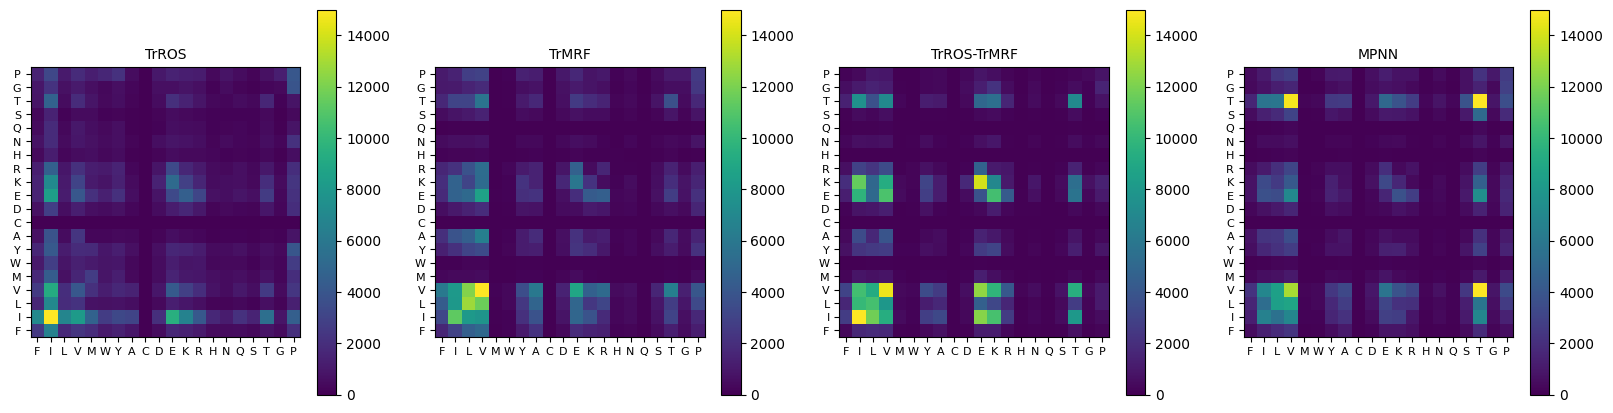

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pairwise_count_1, pairwise_count_2, pairwise_count_3, pairwise_count_4 are your NumPy arrays

# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Plot the reordered matrix on the provided axis
    img = ax.imshow(reordered_matrix, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt


# Create a single row with four subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=15000)

# Plot for result2
plot_reordered_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=15000)

# Plot for result3
plot_reordered_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF", vmin=0, vmax=15000)

# Plot for result4
plot_reordered_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN", vmin=0, vmax=15000)

# plt.savefig('figures/contact_pairs/d<5_counts.png', dpi=300)
plt.show()

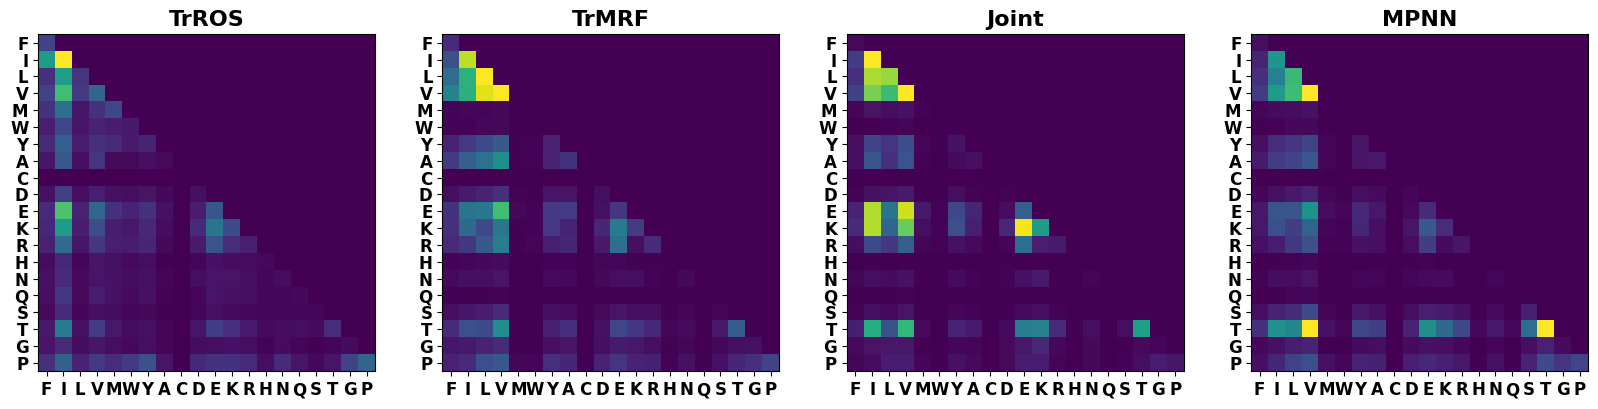

In [155]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None, colorbar=False):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]



    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    if colorbar == True:
        cbar = plt.colorbar(img, format="%d", ax=ax)
        cbar.ax.set_ylabel('Colorbar Label', fontsize=12, weight='bold')
        for l in cbar.ax.yaxis.get_ticklabels():
            l.set_weight("bold")
            l.set_fontsize(12)

    ax.set_title(title, fontsize=16, weight = 'bold')

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')



    return folded_matrix

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# Plot for result1
folded_matrix_1= plot_reordered_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=25000)

# Plot for result2
folded_matrix_2 = plot_reordered_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=25000)

# Plot for result3
folded_matrix_3= plot_reordered_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "Joint", vmin=0, vmax=25000)

# Plot for result4
folded_matrix_4= plot_reordered_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN",  vmin=0, vmax=25000)

# plt.savefig('/home/jupyter-yehlin/DMSV2/figures/contact_pairs/d<5_counts_diagonal.png', dpi=300)

# Show the plot
plt.show()

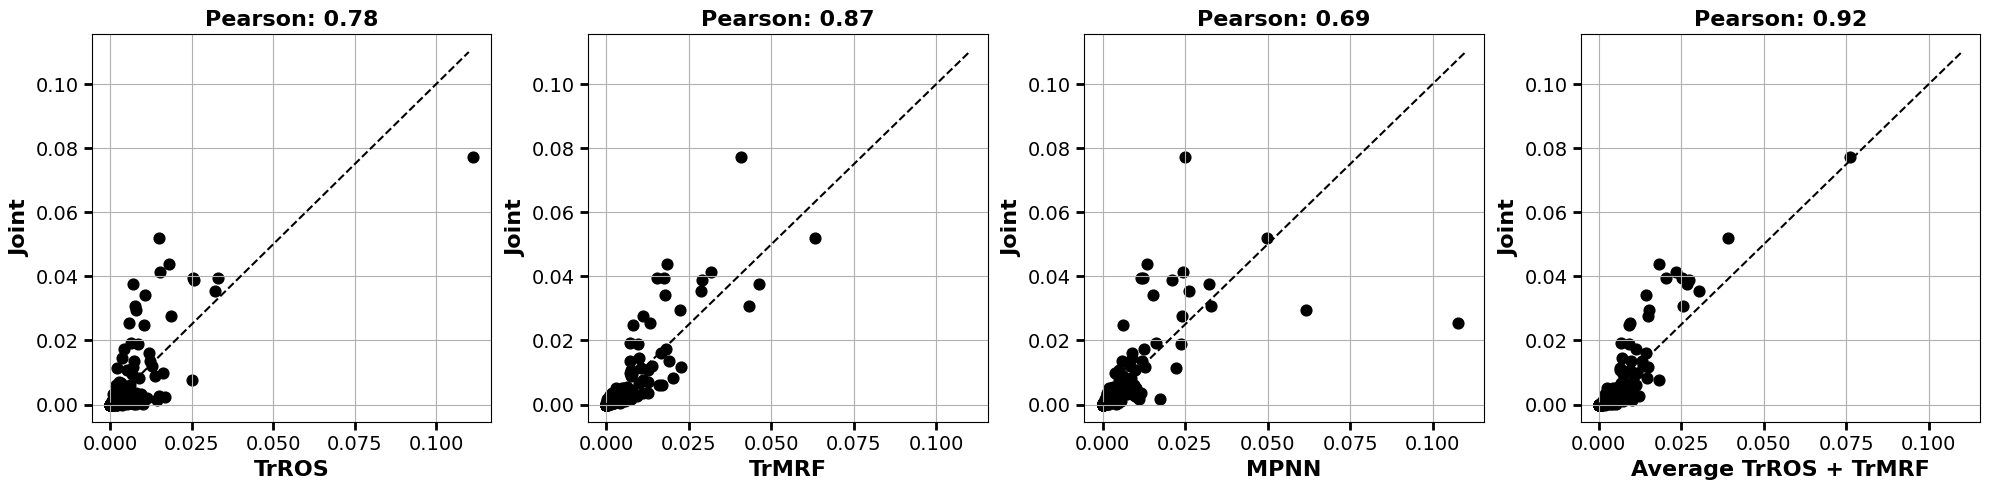

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


A=folded_matrix_1.flatten()/np.sum(folded_matrix_1)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)
# Calculate the minimum and maximum values from both datasets
min_val = 0
max_val = 0.11
# Create three subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1 - Original Scatter Plot
axes[0].scatter(A, B, color='black' , s = 60)
axes[0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[0].set_title("Pearson: {:.2f}".format(pearson_corr),fontsize = 16, weight = "bold")
axes[0].set_xlabel("TrROS",fontsize = 16, weight = "bold")
axes[0].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[0].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[0].grid(True)

A=folded_matrix_2.flatten()/np.sum(folded_matrix_2)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)
# Calculate the minimum and maximum values from both datasets
# Create three subplots in a single row

# Plot 1 - Original Scatter Plot
axes[1].scatter(A, B, color='black', s = 60)
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[1].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[1].set_xlabel("TrMRF",fontsize = 16, weight = "bold")
axes[1].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[1].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[1].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[1].grid(True)



A=folded_matrix_4.flatten()/np.sum(folded_matrix_4)
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)
# Calculate the minimum and maximum values from both datasets
# Create three subplots in a single row

# Plot 1 - Original Scatter Plot
axes[2].scatter(A, B, color='black', s = 60)
axes[2].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[2].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[2].set_xlabel("MPNN",fontsize = 16, weight = "bold")
axes[2].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[2].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[2].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[2].grid(True)



A=(folded_matrix_1.flatten()/np.sum(folded_matrix_1) + folded_matrix_2.flatten()/np.sum(folded_matrix_2))/2
B=folded_matrix_3.flatten()/np.sum(folded_matrix_3)
# Calculate the minimum and maximum values from both datasets
# Create three subplots in a single row

# Plot 1 - Original Scatter Plot
axes[3].scatter(A, B, color='black' , s = 60)
axes[3].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[3].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[3].set_xlabel("Average TrROS + TrMRF",fontsize = 16, weight = "bold")
axes[3].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[3].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[3].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[3].grid(True)

# # Set common labels
# for ax in axes:
#     ax.set_xlabel("Folded Matrix 1")
#     ax.set_ylabel("Folded Matrix 2")
#     ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()


# plt.savefig('/home/jupyter-yehlin/DMSV2/figures/contact_pairs/d<5_counts_diagonal_scatter_plot.png', dpi=300)

plt.show()

<module 'matplotlib.pyplot' from '/opt/tljh/user/lib/python3.9/site-packages/matplotlib/pyplot.py'>

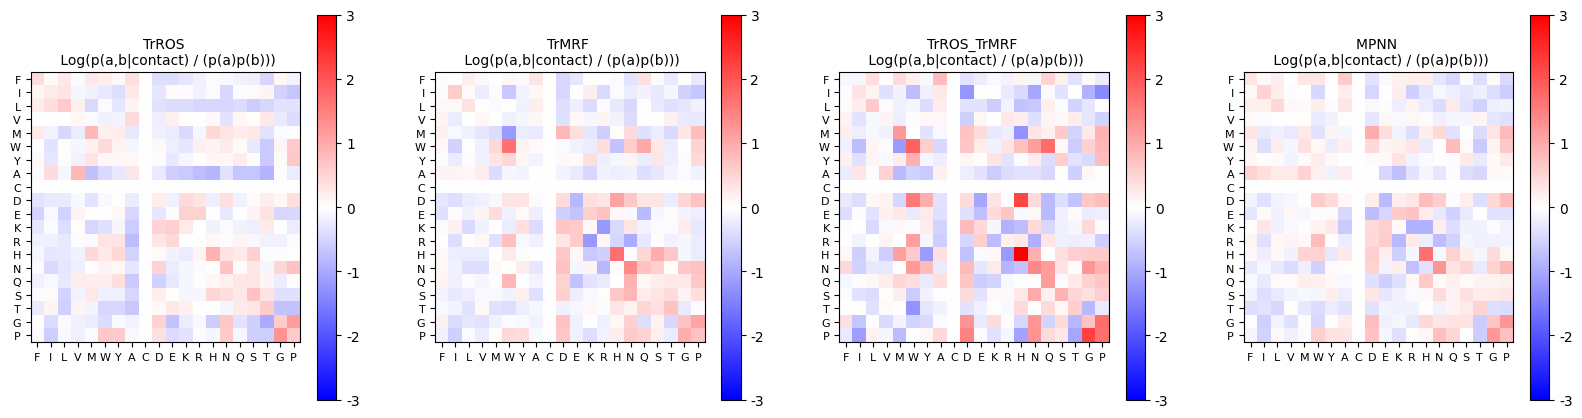

In [39]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax,result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(reordered_matrix)
    p_a = np.sum(reordered_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(reordered_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(20):
            p_ab_contact = reordered_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[i, j] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_reordered_prob_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
plot_reordered_prob_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
plot_reordered_prob_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS_TrMRF")

# Plot for result4
plot_reordered_prob_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

# plt.savefig('figures/contact_pairs/log_p_d<5_counts.png', dpi=300)

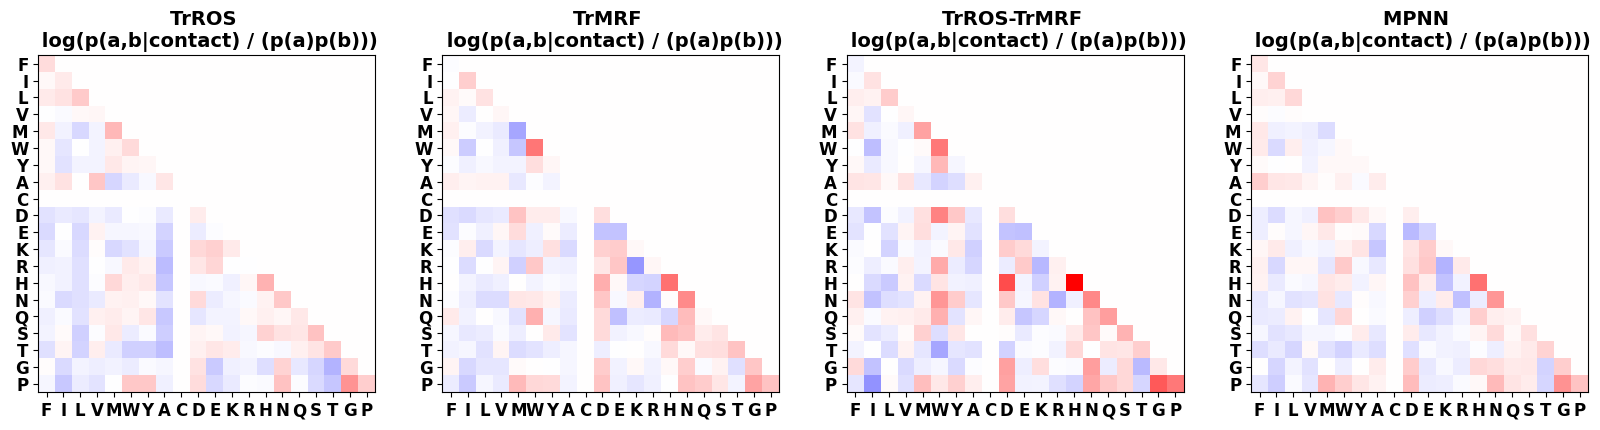

In [103]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax, result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]
            

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]
            folded_matrix[i,j] = reordered_matrix[i, j] + reordered_matrix[j, i]

            
            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(folded_matrix)
    p_a = np.sum(folded_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(folded_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(i,20):
            p_ab_contact = folded_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[j, i] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    # plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n log(p(a,b|contact) / (p(a)p(b)))", fontsize=14, weight='bold')
    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')


    return plt
    

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
plot_reordered_prob_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
plot_reordered_prob_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
plot_reordered_prob_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF")

# Plot for result4
plot_reordered_prob_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

# plt.savefig('figures/contact_pairs/log_p_d<5_counts_diagonal_NO_CB.png', dpi=300)

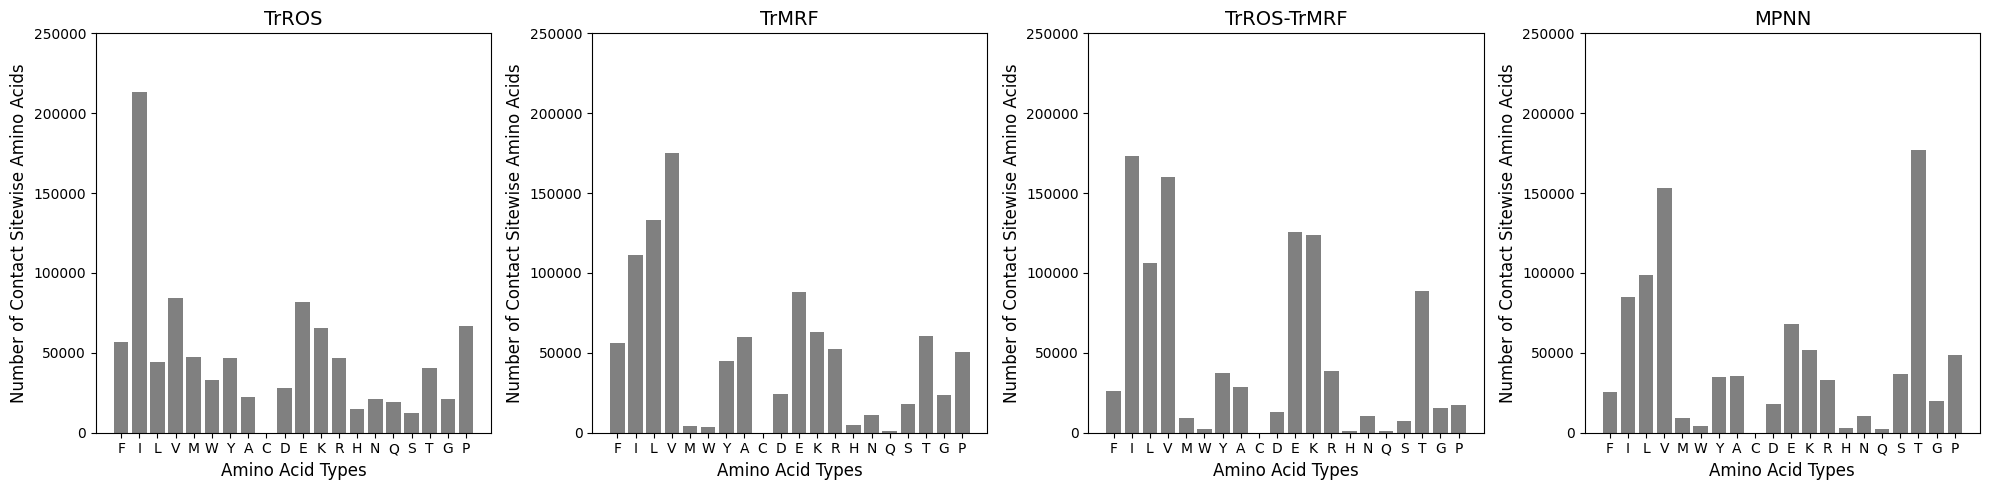

In [108]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    # sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,250000])
    
    
    return sitewise_matrix

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
sitewise_matrix_1= plot_sitewise_subplot(axs[0], np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
sitewise_matrix_2 = plot_sitewise_subplot(axs[1], np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
sitewise_matrix_3 = plot_sitewise_subplot(axs[2], np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF")

# Plot for result4
sitewise_matrix_4 = plot_sitewise_subplot(axs[3], np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

# Adjust layout to prevent clipping of titles
plt.tight_layout()


# plt.savefig('figures/contact_pairs/d<5_sitwewise_counts.png', dpi=300)
# Show the plot
plt.show()

/tmp/ipykernel_1151030/3835640455.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')


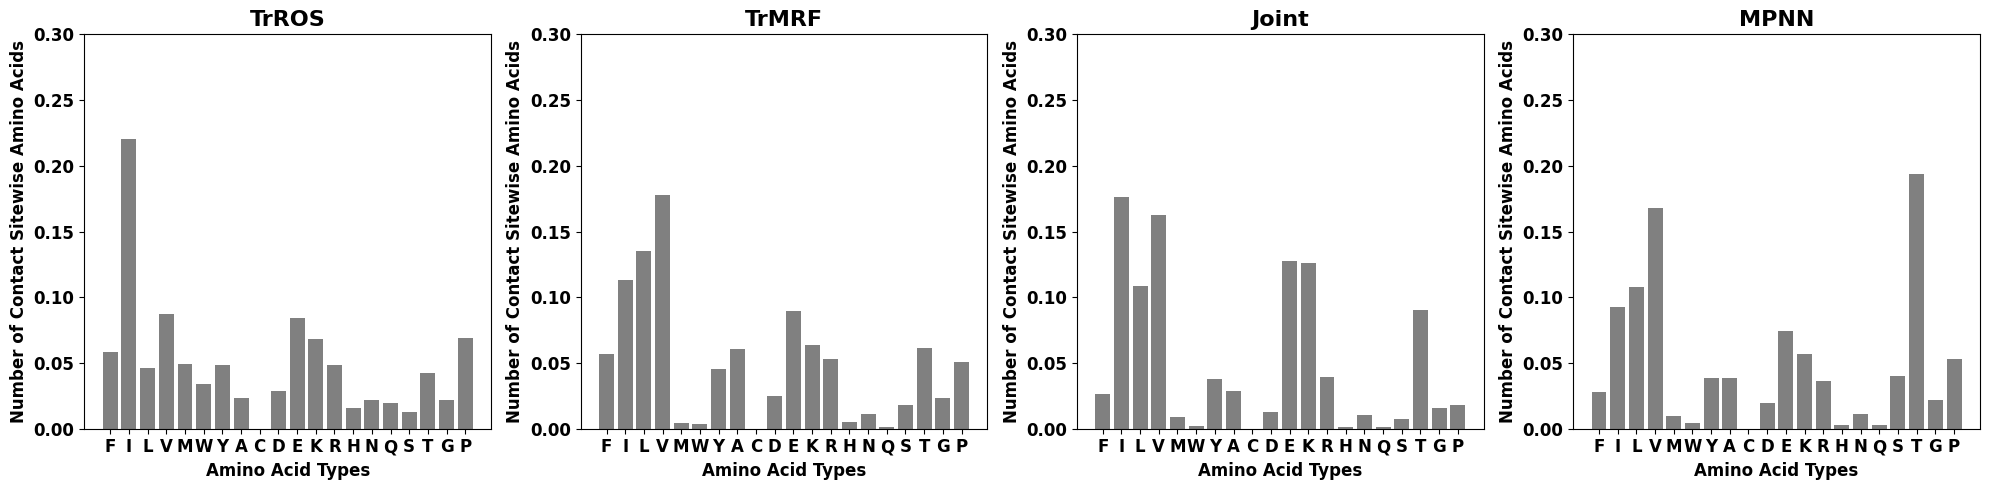

In [125]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title,  fontsize=16, weight='bold')
    ax.set_xlabel('Amino Acid Types',  fontsize=12,  weight='bold')
    ax.set_ylabel('Number of Contact Sitewise Amino Acids',  fontsize=12, weight='bold')
    ax.set_ylim([0,0.3])
    ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')

    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        label.set_fontsize(12)
        label.set_fontweight('bold')

    return sitewise_matrix
    
    
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
sitewise_matrix_1 = plot_sitewise_subplot(axs[0], np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
sitewise_matrix_2 = plot_sitewise_subplot(axs[1], np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
sitewise_matrix_3 =plot_sitewise_subplot(axs[2], np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "Joint")

# Plot for result4
sitewise_matrix_4 = plot_sitewise_subplot(axs[3], np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

# Adjust layout to prevent clipping of titles
plt.tight_layout()


plt.savefig('figures/contact_pairs/d<5_sitwewise_prob.png', dpi=300)
# Show the plot
plt.show()

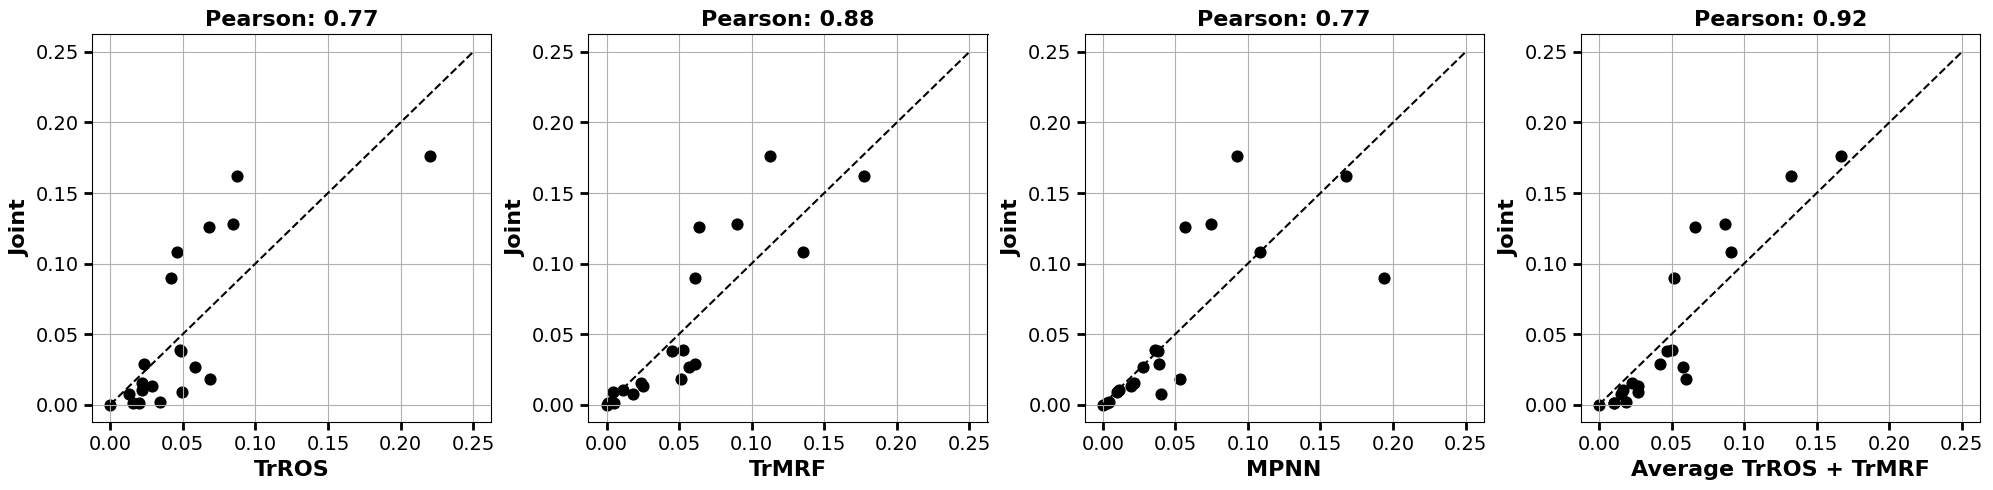

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


A=sitewise_matrix_1
B=sitewise_matrix_3
# Calculate the minimum and maximum values from both datasets
min_val = 0
max_val = 0.25
# Create three subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1 - Original Scatter Plot
axes[0].scatter(A, B, color='black', s =60)
axes[0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[0].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[0].set_xlabel("TrROS",fontsize = 16, weight = "bold")
axes[0].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[0].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[0].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[0].grid(True)

A=sitewise_matrix_2
B=sitewise_matrix_3


# Plot 1 - Original Scatter Plot
axes[1].scatter(A, B, color='black', s =60)
axes[1].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[1].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[1].set_xlabel("TrMRF",fontsize = 16, weight = "bold")
axes[1].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[1].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[1].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[1].grid(True)


A=sitewise_matrix_4
B=sitewise_matrix_3


# Plot 1 - Original Scatter Plot
axes[2].scatter(A, B, color='black', s =60)
axes[2].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[2].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[2].set_xlabel("MPNN",fontsize = 16, weight = "bold")
axes[2].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[2].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[2].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[2].grid(True)


A=(sitewise_matrix_1 + sitewise_matrix_2)/2
B=sitewise_matrix_3


# Plot 1 - Original Scatter Plot
axes[3].scatter(A, B, color='black', s =60)
axes[3].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')  # x=y line

# Calculate Pearson correlation coefficient
pearson_corr, _ = scipy.stats.pearsonr(A, B)
spearman_corr, _ = scipy.stats.spearmanr(A, B)
axes[3].set_title("Pearson: {:.2f}".format(pearson_corr), fontsize = 16, weight = "bold")
axes[3].set_xlabel("Average TrROS + TrMRF",fontsize = 16, weight = "bold")
axes[3].set_ylabel("Joint" ,fontsize = 16, weight = "bold")
axes[3].tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label font size
axes[3].tick_params(axis='both', which='major', width=2, length=6)  # Adjust tick size and width
axes[3].grid(True)


# # Set common labels
# for ax in axes:
#     ax.set_xlabel("Folded Matrix 1")
#     ax.set_ylabel("Folded Matrix 2")
#     ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig('/home/jupyter-yehlin/DMSV2/figures/contact_pairs/d<5_sitwewise_counts_scatter.png', dpi=300)

plt.show()

In [152]:
# list('FILVMWYACDEKRHNQSTGP')[17]

## pair within 3A

In [355]:
filtered_df_1 = filtered_df_1[filtered_df_1['pairwise_count_3A'].notna()]
filtered_df_2 = filtered_df_2[filtered_df_2['pairwise_count_3A'].notna()]
filtered_df_3 = filtered_df_3[filtered_df_3['pairwise_count_3A'].notna()]
filtered_df_4 = filtered_df_4[filtered_df_4['pairwise_count_3A'].notna()]

In [356]:
pairwise_count_1 = [item[0] if isinstance(item, (list, tuple)) else item for item in filtered_df_1['pairwise_count_3A'].tolist()]
pairwise_count_2 = [item[0] if isinstance(item, (list, tuple)) else item for item in filtered_df_2['pairwise_count_3A'].tolist()]
pairwise_count_3 = [item[0] if isinstance(item, (list, tuple)) else item for item in filtered_df_3['pairwise_count_3A'].tolist()]
pairwise_count_4 = [item[0] if isinstance(item, (list, tuple)) else item for item in filtered_df_4['pairwise_count_3A'].tolist()]

In [357]:
# # Assuming pairwise_count_1 is a list of lists or arrays
# # Ensure all elements have the same length
# max_length = max(len(item) for item in pairwise_count_1)
# pairwise_count_1_padded = [item + [0] * (max_length - len(item)) for item in pairwise_count_1]

# # Convert the list to a NumPy array and then perform the summation
# result = np.sum(np.array(pairwise_count_1_padded), axis=0)

In [358]:
import numpy as np
result1 = np.array(np.sum(pairwise_count_1, axis=0)).reshape(21,21)
result2 = np.array(np.sum(pairwise_count_2, axis=0)).reshape(21,21)
result3 = np.array(np.sum(pairwise_count_3, axis=0)).reshape(21,21)
result4 = np.array(np.sum(pairwise_count_4, axis=0)).reshape(21,21)

In [359]:
print("TrROS", np.sum(result1))
print("TrMRF", np.sum(result2))
print("TrROS_Hall", np.sum(result3))
print("JUSTAS", np.sum(result4))

TrROS 129936
TrMRF 126598
TrROS_Hall 72389
JUSTAS 117192


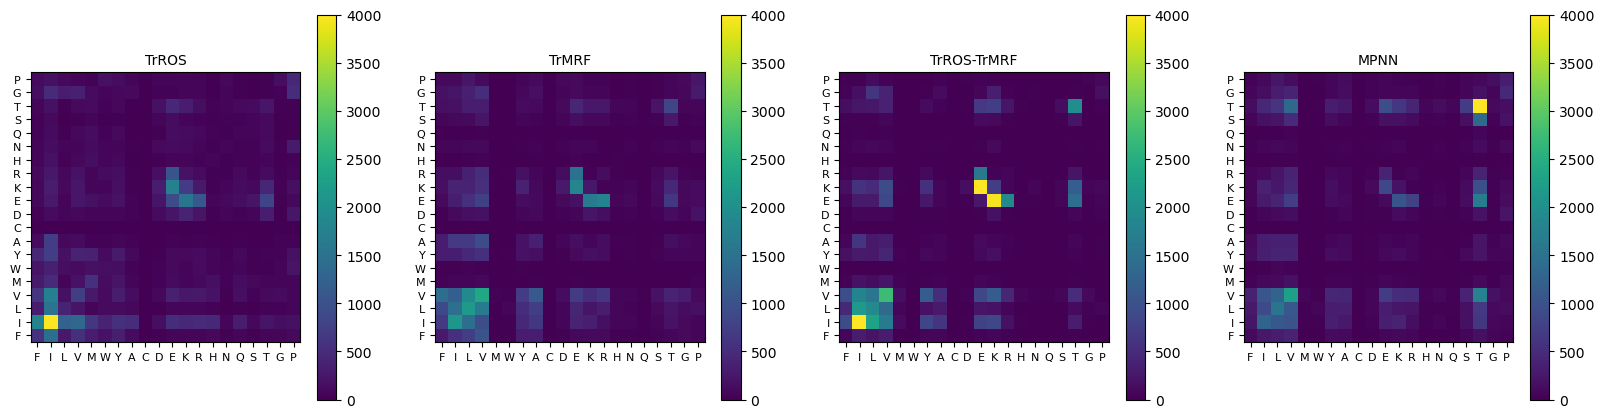

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pairwise_count_1, pairwise_count_2, pairwise_count_3, pairwise_count_4 are your NumPy arrays

# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Plot the reordered matrix on the provided axis
    img = ax.imshow(reordered_matrix, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt


# Create a single row with four subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=4000)

# Plot for result2
plot_reordered_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=4000)

# Plot for result3
plot_reordered_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF", vmin=0, vmax=4000)

# Plot for result4
plot_reordered_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN", vmin=0, vmax=4000)

# plt.savefig('figures/contact_pairs/d<3_counts.png', dpi=300)
plt.show()

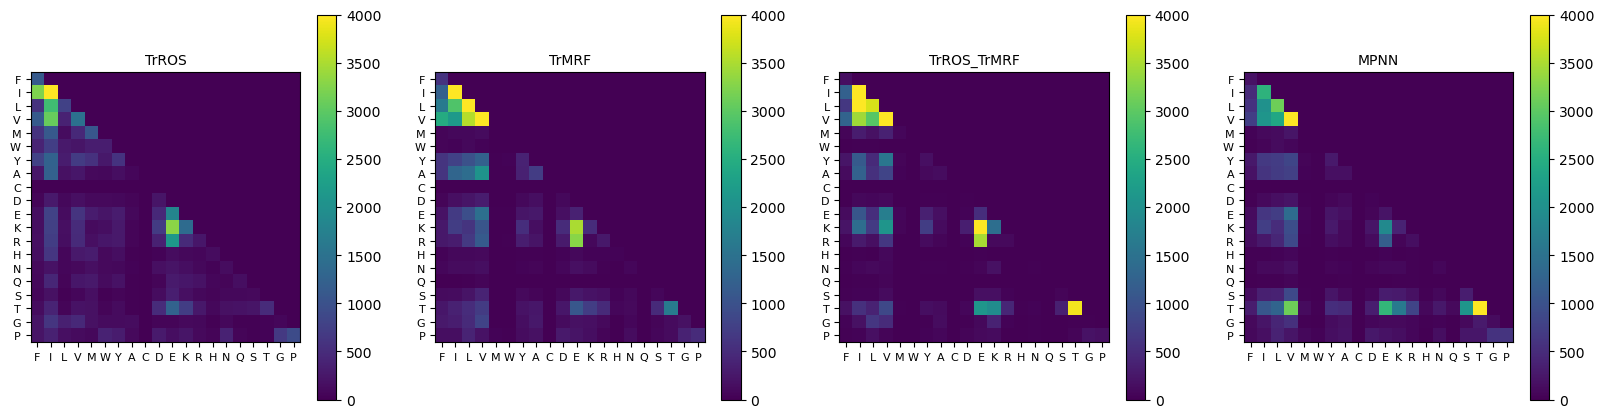

In [31]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]



    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=4000)

# Plot for result2
plot_reordered_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=4000)

# Plot for result3
plot_reordered_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS_TrMRF", vmin=0, vmax=4000)

# Plot for result4
plot_reordered_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN",  vmin=0, vmax=4000)

# plt.savefig('figures/contact_pairs/d<3_counts_diagonal.png', dpi=300)

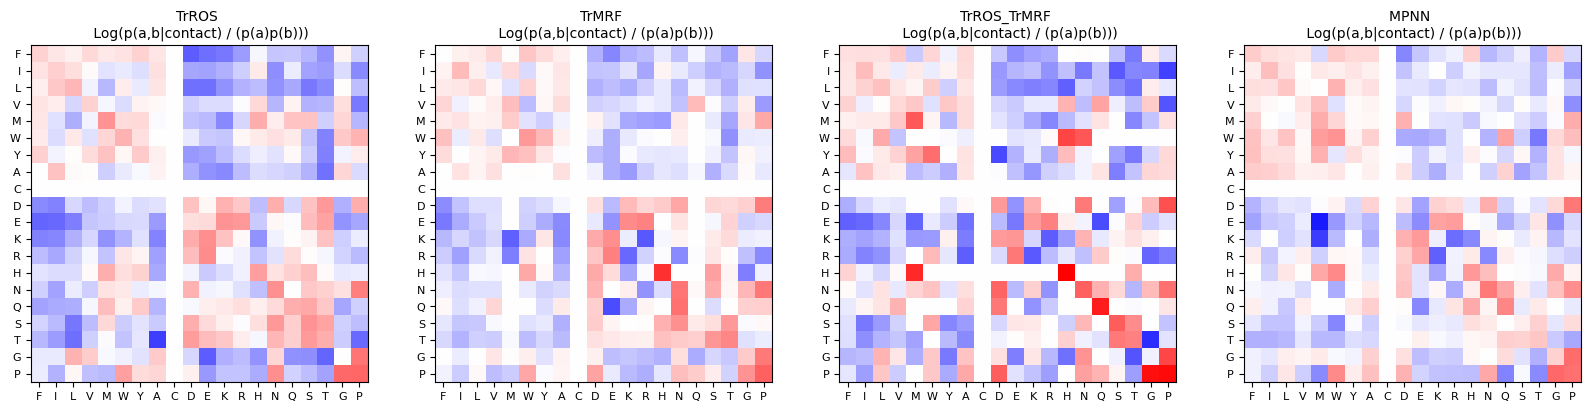

In [333]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax,result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(reordered_matrix)
    p_a = np.sum(reordered_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(reordered_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(20):
            p_ab_contact = reordered_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[i, j] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    # if ax ==axs[3]:
        # plt.colorbar(img, format="%d", ax=ax,pad=0.1)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_reordered_prob_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
plot_reordered_prob_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
plot_reordered_prob_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS_TrMRF")

# Plot for result4
plot_reordered_prob_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

plt.savefig('figures/contact_pairs/log_p_d<3_counts_no_cb.png', dpi=300)

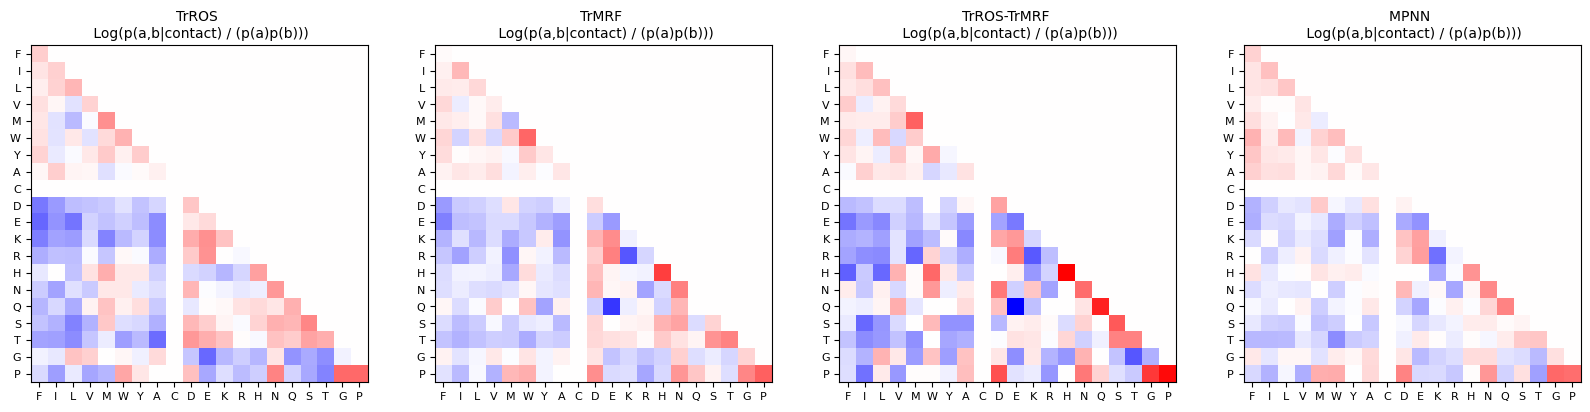

In [360]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax, result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]
            

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]
            folded_matrix[i,j] = reordered_matrix[i, j] + reordered_matrix[j, i]

            
            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(folded_matrix)
    p_a = np.sum(folded_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(folded_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(i,20):
            p_ab_contact = folded_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[j, i] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    # plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt
    

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
plot_reordered_prob_matrix(axs[0],np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
plot_reordered_prob_matrix(axs[1],np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
plot_reordered_prob_matrix(axs[2],np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF")

# Plot for result4
plot_reordered_prob_matrix(axs[3],np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")


# plt.savefig('figures/contact_pairs/log_p_d<3_counts_diagonal_no_cb.png', dpi=300)

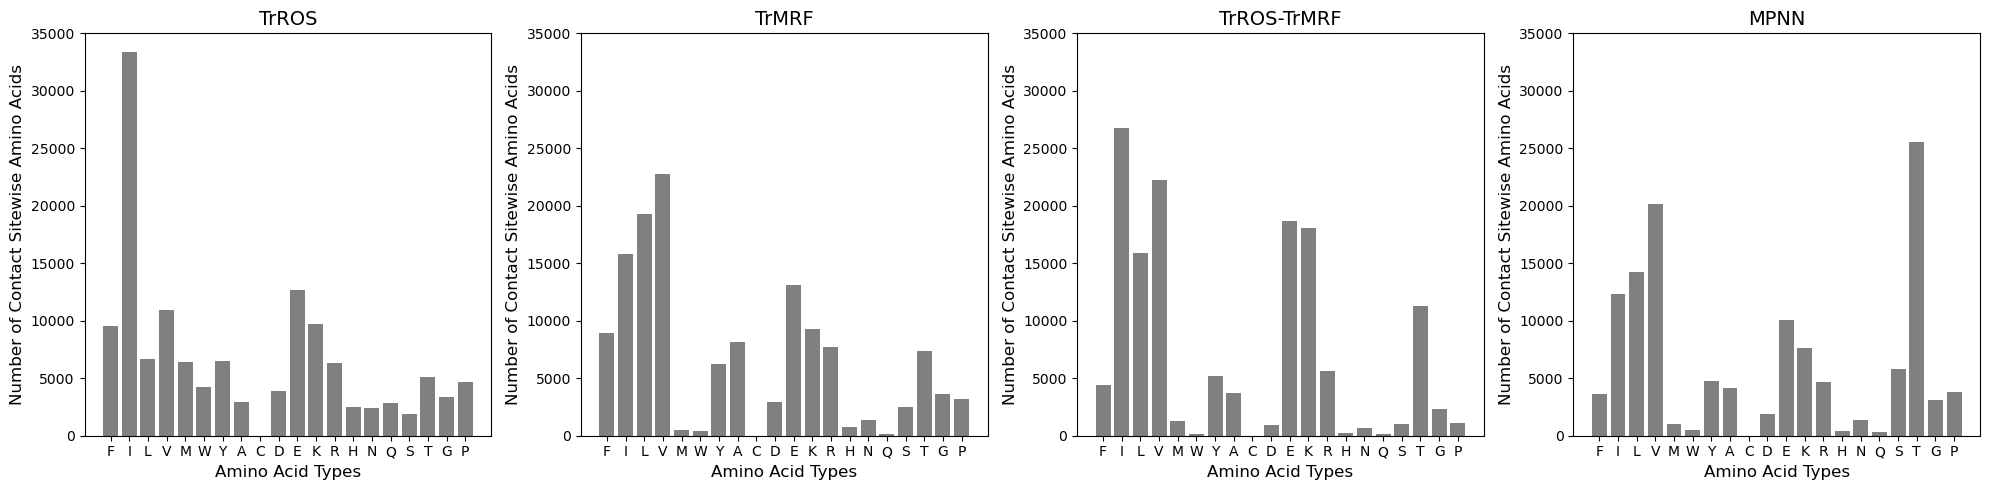

In [74]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    # sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,35000])

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
plot_sitewise_subplot(axs[0], np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
plot_sitewise_subplot(axs[1], np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
plot_sitewise_subplot(axs[2], np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF")

# Plot for result4
plot_sitewise_subplot(axs[3], np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot


# plt.savefig('figures/contact_pairs/d<3_sitewise_counts.png', dpi=300)

plt.show()

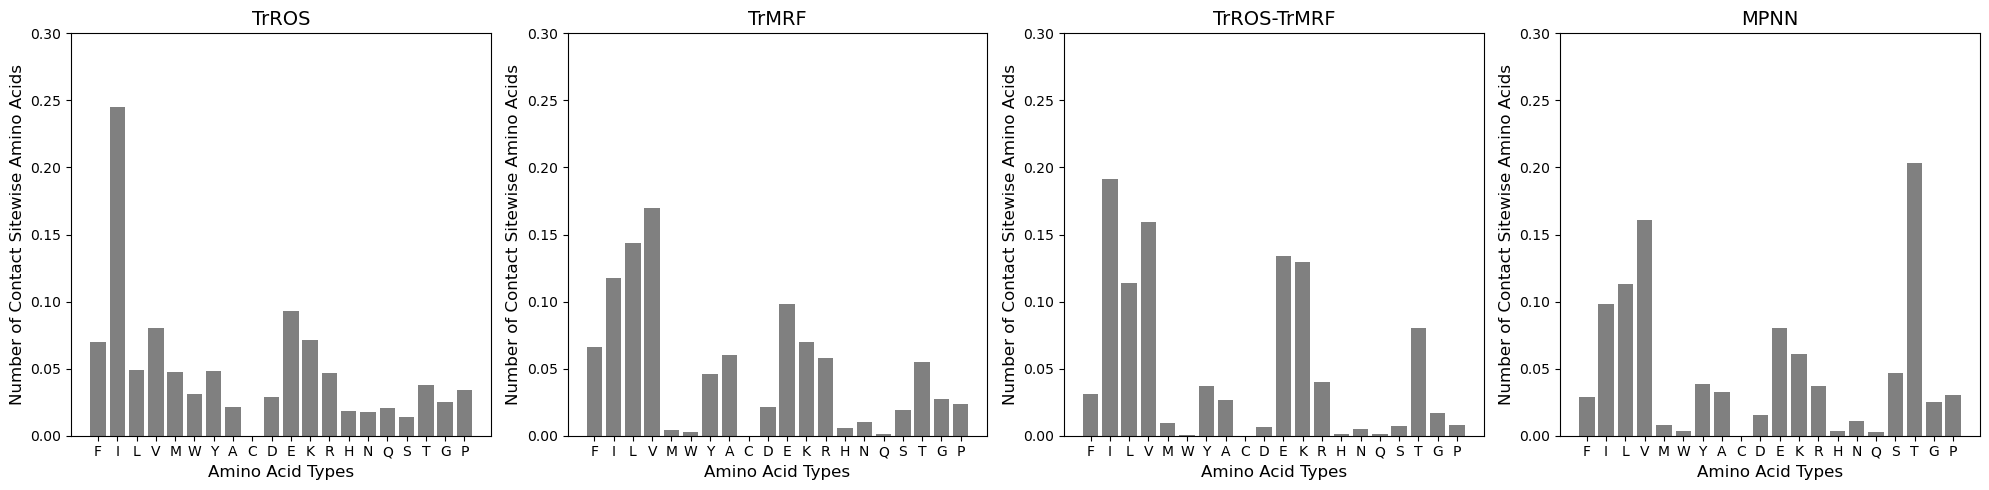

In [114]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,0.3])

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
plot_sitewise_subplot(axs[0], np.array(np.sum(pairwise_count_1, axis=0)).reshape(21, 21), "TrROS")

# Plot for result2
plot_sitewise_subplot(axs[1], np.array(np.sum(pairwise_count_2, axis=0)).reshape(21, 21), "TrMRF")

# Plot for result3
plot_sitewise_subplot(axs[2], np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrROS-TrMRF")

# Plot for result4
plot_sitewise_subplot(axs[3], np.array(np.sum(pairwise_count_4, axis=0)).reshape(21, 21), "MPNN")

# Adjust layout to prevent clipping of titles
plt.tight_layout()


# plt.savefig('figures/contact_pairs/d<3_sitwewise_prob.png', dpi=300)
# Show the plot
plt.show()

## pair within 3A - 5A

## NATIVE PDB pairwise analysis within 5A

In [133]:
import re
import ast
import pandas as pd
import numpy as np


# Function to add commas to the list-like string and convert it to a list
def fix_list_str(input_str):
    # Add commas between numbers
    fixed_str = re.sub(r'(\d+)', r'\1, ', input_str)
    # Add brackets and convert to a list
    return ast.literal_eval(f"[{fixed_str}]")

# Read CSV file
df = pd.read_csv('pairwise_counts_native_5A.csv')
df['pairwise_count'] = df['pairwise_count'].apply(fix_list_str)
df_3A = pd.read_csv('pairwise_counts_native_3A.csv')
df_3A['pairwise_count'] = df_3A['pairwise_count'].apply(fix_list_str)

merged_df = pd.merge(df, df_3A[['name', 'pairwise_count']], on='name', how='left')

merged_df = merged_df.rename(columns={'pairwise_count_x': 'pairwise_count_5A', 'pairwise_count_y': 'pairwise_count_3A'})


merged_df['new_column'] = [
    np.array(inner_list_5A) - np.array(inner_list_3A)
    for inner_list_5A, inner_list_3A in zip(merged_df['pairwise_count_5A'], merged_df['pairwise_count_3A'])
]

merged_df.rename(columns={'new_column': 'pairwise_count_3A_5A'})

# merged_df.to_csv('pairwise_counts_native_total.csv', index=False)

,name,pairwise_count_5A,pairwise_count_3A,pairwise_count_3A_5A
0,4il7A.pdb,"[[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
1,2g7sA.pdb,"[[0, 0, 0, 0, 5, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 5, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0,..."
2,3hnxA.pdb,"[[2, 0, 1, 0, 1, 0, 1, 1, 0, 3, 0, 1, 2, 0, 3,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 0, 1, 0, 1, 0, 1, 1, 0, 3, 0, 1, 2, 0, 3,..."
3,2g1uA.pdb,"[[1, 0, 0, 0, 4, 0, 0, 4, 1, 2, 0, 1, 0, 0, 1,...","[[0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1,...","[[1, 0, 0, 0, 4, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0,..."
4,2wcwA.pdb,"[[7, 0, 1, 2, 4, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1,...","[[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,...","[[7, 0, 1, 1, 4, 0, 0, 2, 1, 1, 0, 2, 2, 0, 1,..."
...,...,...,...,...
167,4blgA.pdb,"[[1, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0,..."
168,2ic6A.pdb,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1,...",NaN,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
169,2qv0A.pdb,"[[0, 0, 0, 0, 2, 0, 0, 1, 1, 3, 0, 0, 1, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 2, 0, 0, 1, 1, 3, 0, 0, 1, 0, 0,..."
170,5kf4A.pdb,"[[1, 0, 0, 3, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 0, 3, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0,..."


In [134]:
df = merged_df

In [135]:
pairwise_count_native=[item[0] for item in df['pairwise_count_5A'].tolist()]

In [136]:
import numpy as np
result_native = np.array(np.sum(pairwise_count_native, axis=0)).reshape(21,21)

In [137]:
print("native", np.sum(result_native))

native 35938


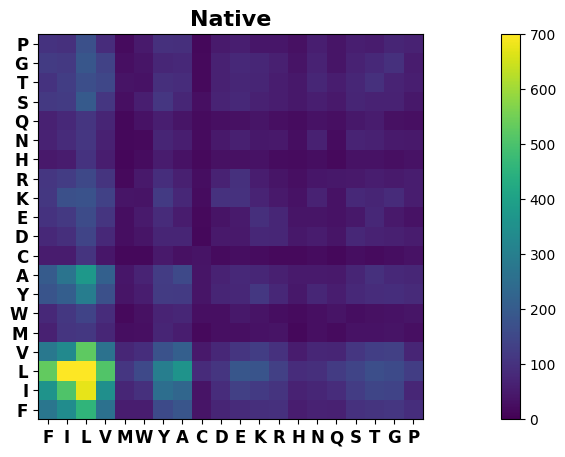

In [139]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pairwise_count_1, pairwise_count_2, pairwise_count_3, pairwise_count_4 are your NumPy arrays

# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Plot the reordered matrix on the provided axis
    img = ax.imshow(reordered_matrix, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=16, weight = 'bold')

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')




    return plt


# Create a single row with four subplots
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native", vmin=0, vmax=700)

# plt.savefig('figures/contact_pairs/native_d<5_counts.png', dpi=300)
plt.show()

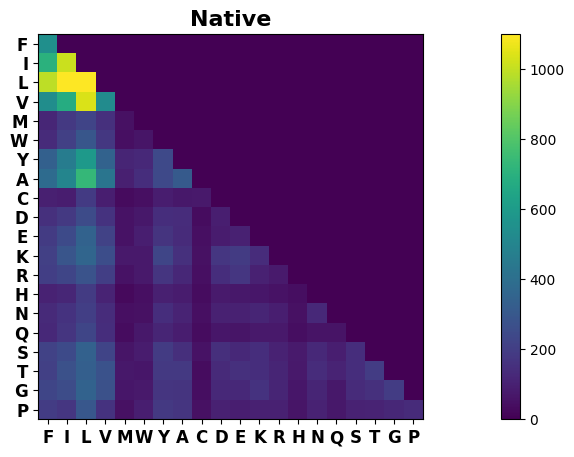

In [141]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]



    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed

    ax.set_title(title, fontsize=16, weight = 'bold')

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')




    return plt

fig, axs = plt.subplots(1,1, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native", vmin=0, vmax=1100)

# plt.savefig('figures/contact_pairs/native_d<5_counts_diagonal.png', dpi=300)

# Show the plot
plt.show()

In [383]:
# # Plot for result1
# plot_reordered_matrix(np.array(np.sum(np.array(pairwise_count_1+pairwise_count_2)/2, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=25000)

# # Plot for result2
# plot_reordered_matrix(np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=25000)

<module 'matplotlib.pyplot' from '/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/matplotlib/pyplot.py'>

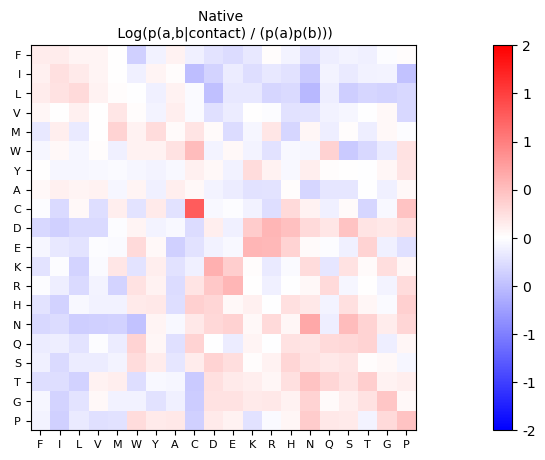

In [384]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax,result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(reordered_matrix)
    p_a = np.sum(reordered_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(reordered_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(20):
            p_ab_contact = reordered_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[i, j] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -2 # Your desired minimum value
    vmax = 2  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1, 1, figsize=(20, 5))
plot_reordered_prob_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")

# plt.savefig('figures/contact_pairs/native_log_p_d<5_counts.png', dpi=300)

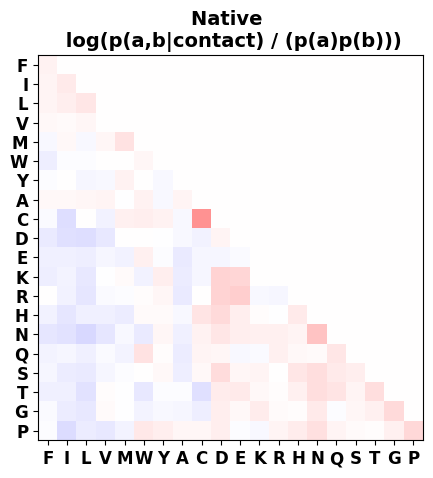

In [143]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax, result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]
            

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]
            folded_matrix[i,j] = reordered_matrix[i, j] + reordered_matrix[j, i]

            
            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(folded_matrix)
    p_a = np.sum(folded_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(folded_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(i,20):
            p_ab_contact = folded_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[j, i] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    # plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    # plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n log(p(a,b|contact) / (p(a)p(b)))", fontsize=14, weight='bold')
    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=12, weight='bold')

    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=12, weight='bold')



    return plt
    

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

# Plot for result1
plot_reordered_prob_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


# plt.savefig('figures/contact_pairs/native/native_log_p_d<5_counts_diagonal_NO_CB.png', dpi=300)

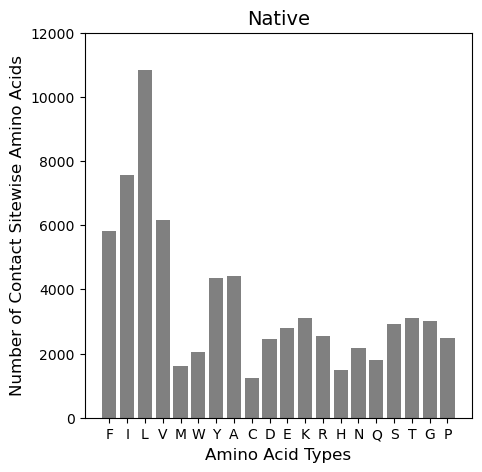

In [387]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    # sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,12000])

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot for result1
plot_sitewise_subplot(axs, np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


# plt.savefig('figures/contact_pairs/native_d<5_sitwewise_counts.png', dpi=300)
# Show the plot
plt.show()

/tmp/ipykernel_1151030/1732728282.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')


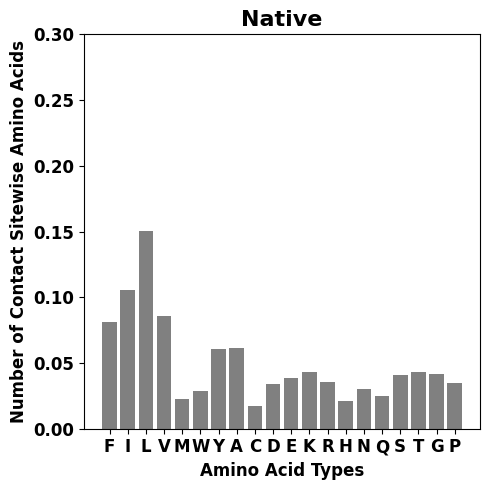

In [146]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title,  fontsize=16, weight='bold')
    ax.set_xlabel('Amino Acid Types',  fontsize=12,  weight='bold')
    ax.set_ylabel('Number of Contact Sitewise Amino Acids',  fontsize=12, weight='bold')
    ax.set_ylim([0,0.3])
    ax.set_xticklabels(list(desired_order), fontsize=12, fontweight='bold')

    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        label.set_fontsize(12)
        label.set_fontweight('bold')

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot for result1
plot_sitewise_subplot(axs, np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


plt.tight_layout()
# plt.savefig('figures/contact_pairs/native_d<5_sitwewise_prob.png', dpi=300)
# Show the plot
plt.show()

## NATIVE PDB pairwise analysis within 3A

In [389]:
pairwise_count_native = [item[0] for item in df['pairwise_count_3A'].tolist() if isinstance(item, (list))]

In [390]:
# # len(df['pairwise_count_3A'].tolist()[0][0])

# for item in df['pairwise_count_3A'].tolist():
#     try:
#         print(len(item[0]))
#     except:
#         continue

In [391]:
import numpy as np
result_native = np.array(np.sum(pairwise_count_native, axis=0)).reshape(21,21)

In [392]:
print("Native", np.sum(result_native))

Native 3152


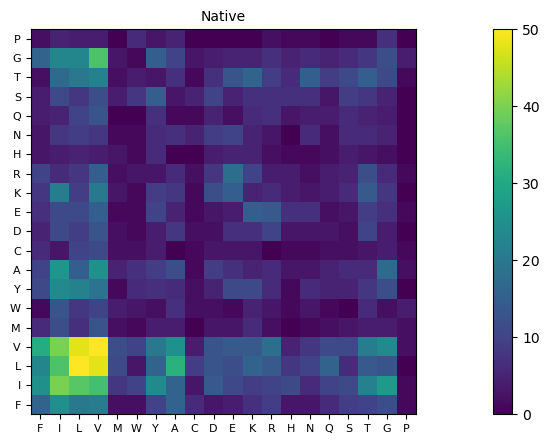

In [393]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pairwise_count_1, pairwise_count_2, pairwise_count_3, pairwise_count_4 are your NumPy arrays

# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Plot the reordered matrix on the provided axis
    img = ax.imshow(reordered_matrix, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt


# Create a single row with four subplots
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native", vmin=0, vmax=50)

# plt.savefig('figures/contact_pairs/native_d<3_counts.png', dpi=300)
plt.show()

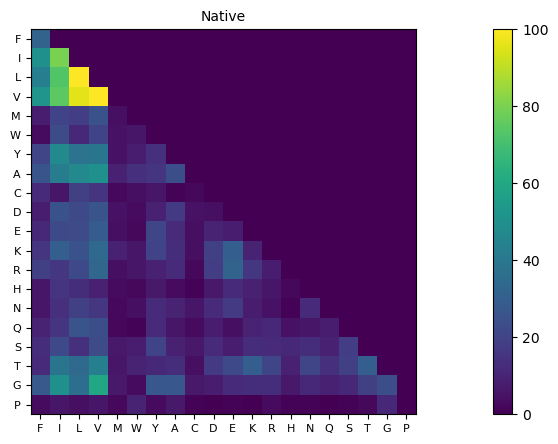

In [394]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]



    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1,1, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native", vmin=0, vmax=100)

# plt.savefig('figures/contact_pairs/native_d<3_counts_diagonal.png', dpi=300)

# Show the plot
plt.show()

In [395]:
# # Plot for result1
# plot_reordered_matrix(np.array(np.sum(np.array(pairwise_count_1+pairwise_count_2)/2, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=25000)

# # Plot for result2
# plot_reordered_matrix(np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=25000)

<module 'matplotlib.pyplot' from '/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/matplotlib/pyplot.py'>

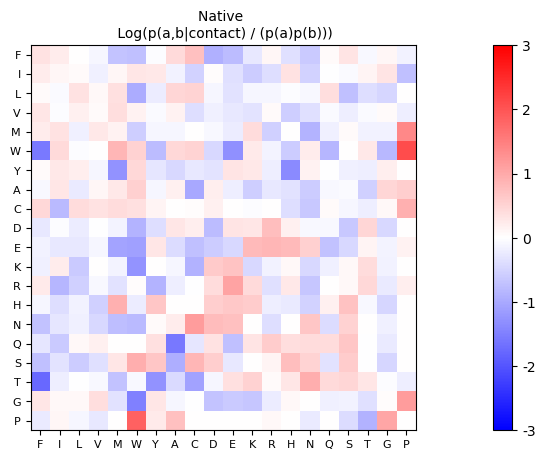

In [396]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax,result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(reordered_matrix)
    p_a = np.sum(reordered_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(reordered_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(20):
            p_ab_contact = reordered_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[i, j] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1, 1, figsize=(20, 5))
plot_reordered_prob_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")

# plt.savefig('figures/contact_pairs/native_log_p_d<3_counts.png', dpi=300)

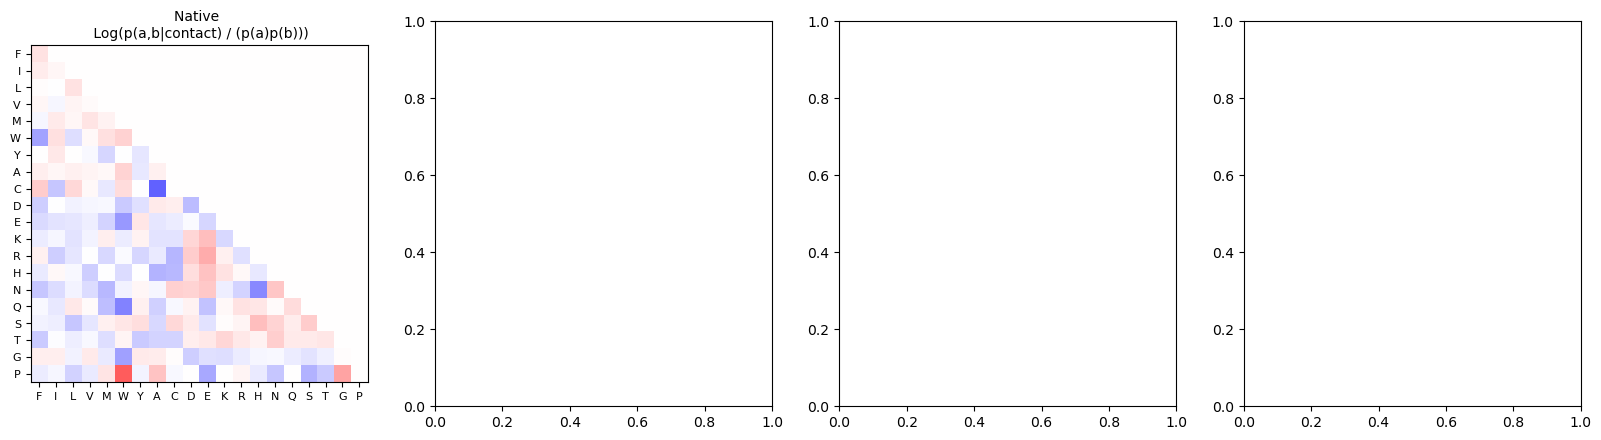

In [397]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax, result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]
            

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]
            folded_matrix[i,j] = reordered_matrix[i, j] + reordered_matrix[j, i]

            
            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(folded_matrix)
    p_a = np.sum(folded_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(folded_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(i,20):
            p_ab_contact = folded_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[j, i] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -3 # Your desired minimum value
    vmax = 3  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    # plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt
    

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot for result1
plot_reordered_prob_matrix(axs[0],np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


# plt.savefig('figures/contact_pairs/native/native_log_p_d<3_counts_diagonal_no_cb.png', dpi=300)

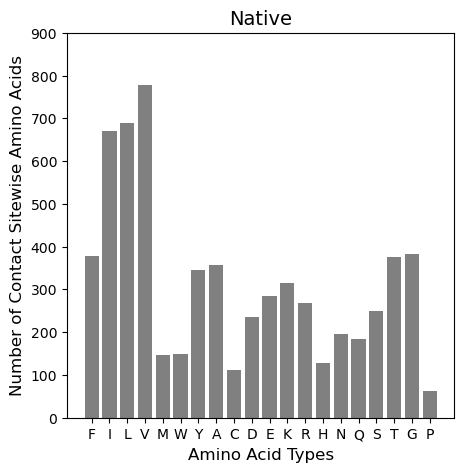

In [398]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    # sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,900])

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot for result1
plot_sitewise_subplot(axs, np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


# plt.savefig('figures/contact_pairs/native_d<3_sitwewise_counts.png', dpi=300)
# Show the plot
plt.show()

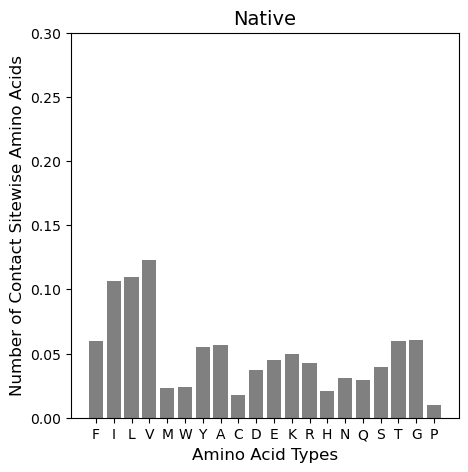

In [399]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,0.3])

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot for result1
plot_sitewise_subplot(axs, np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")



# plt.savefig('figures/contact_pairs/native_d<3_sitwewise_prob.png', dpi=300)
# Show the plot
plt.show()

## NATIVE PDB pairwise analysis within 3A - 5A

In [400]:
import math

pairwise_count_native = [item[0] for item in df['new_column'].tolist() if not math.isnan(item[0][0])]

In [401]:
import numpy as np
result_native = np.array(np.sum(pairwise_count_native, axis=0)).reshape(21,21)

In [402]:
print("Native", np.sum(result_native))

Native 31679


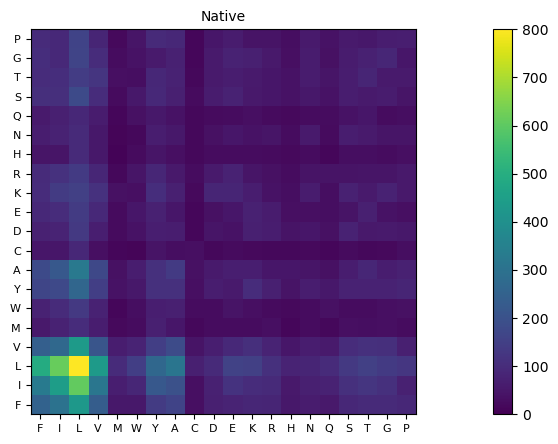

In [403]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pairwise_count_1, pairwise_count_2, pairwise_count_3, pairwise_count_4 are your NumPy arrays

# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Plot the reordered matrix on the provided axis
    img = ax.imshow(reordered_matrix, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt


# Create a single row with four subplots
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native", vmin=0, vmax=800)

# plt.savefig('figures/contact_pairs/native_3<d<5_counts.png', dpi=300)
plt.show()

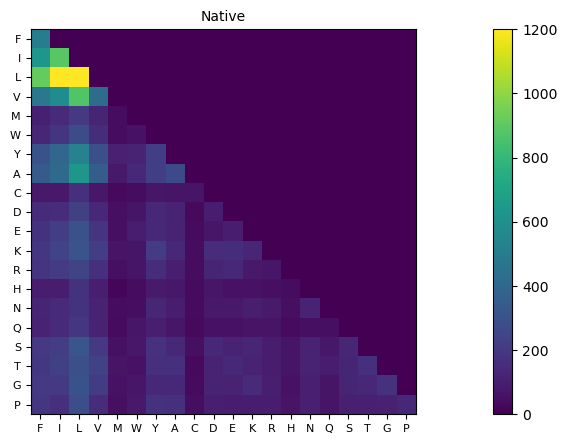

In [404]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

def plot_reordered_matrix(ax, result_matrix, title, vmin=None, vmax=None):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]



    # Plot the reordered matrix on the provided axis
    img = ax.imshow(folded_matrix, cmap='viridis', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(title, fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1,1, figsize=(20, 5))
# Plot for result1
plot_reordered_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native", vmin=0, vmax=1200)

# plt.savefig('figures/contact_pairs/native_3<d<5_counts_diagonal.png', dpi=300)

# Show the plot
plt.show()

In [405]:
# # Plot for result1
# plot_reordered_matrix(np.array(np.sum(np.array(pairwise_count_1+pairwise_count_2)/2, axis=0)).reshape(21, 21), "TrROS", vmin=0, vmax=25000)

# # Plot for result2
# plot_reordered_matrix(np.array(np.sum(pairwise_count_3, axis=0)).reshape(21, 21), "TrMRF", vmin=0, vmax=25000)

<module 'matplotlib.pyplot' from '/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/matplotlib/pyplot.py'>

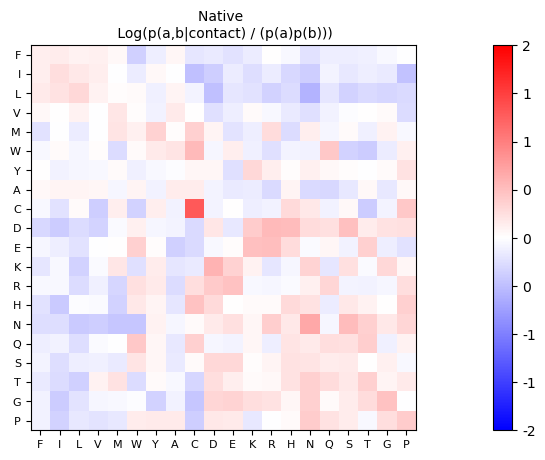

In [406]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax,result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(reordered_matrix)
    p_a = np.sum(reordered_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(reordered_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(20):
            p_ab_contact = reordered_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[i, j] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -2 # Your desired minimum value
    vmax = 2  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt

fig, axs = plt.subplots(1, 1, figsize=(20, 5))
plot_reordered_prob_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")

# plt.savefig('figures/contact_pairs/native_3<log_p_d<5_counts.png', dpi=300)

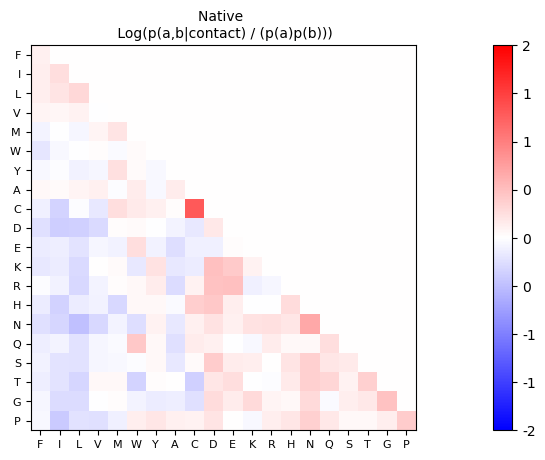

In [408]:
import math 
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}

# Function to reorder and plot the matrix
def plot_reordered_prob_matrix(ax, result_matrix, title):
    # Exclude the 20st row and column
    matrix = result_matrix[:20, :20]

    # Reorder the matrix
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]
            

    # Fold and sum the diagonal
    folded_matrix = np.zeros_like(reordered_matrix)
    for i in range(20):
        for j in range(i, 20):  # Only sum values where j >= i
            folded_matrix[j,i] = reordered_matrix[i, j] + reordered_matrix[j, i]
            folded_matrix[i,j] = reordered_matrix[i, j] + reordered_matrix[j, i]

            
            

    contact_matrix = np.zeros((20, 20))
    matrix_sum = np.sum(folded_matrix)
    p_a = np.sum(folded_matrix, axis=1)/matrix_sum  # Sum along rows to get p(a)
    p_b = np.sum(folded_matrix, axis=0)/matrix_sum  # Sum along columns to get p(b)

    for i in range(20):
        for j in range(i,20):
            p_ab_contact = folded_matrix[i, j]/matrix_sum

            # Avoid division by zero errors
            if p_a[i] > 0 and p_b[j] > 0:
                if p_ab_contact !=0:
                    contact_matrix[j, i] = math.log(p_ab_contact/ (p_a[i] * p_b[j]))

    vmin = -2 # Your desired minimum value
    vmax = 2  # Your desired maximum value

    
    img = ax.imshow(contact_matrix, cmap='bwr', origin='upper', vmin=vmin, vmax=vmax)
    plt.colorbar(img, format="%d", ax=ax)  # Specify format as integer if needed
    ax.set_title(f"{title} \n Log(p(a,b|contact) / (p(a)p(b)))", fontsize=10)

    custom_ticks = np.arange(20)
    custom_ticklabels = list(desired_order)

    ax.set_xticks(custom_ticks)
    ax.set_xticklabels(custom_ticklabels, fontsize=8)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticklabels, fontsize=8)



    return plt
    

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

# Plot for result1
plot_reordered_prob_matrix(axs,np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


# plt.savefig('figures/contact_pairs/native/native_3<log_p_d<5_counts_diagonal.png', dpi=300)

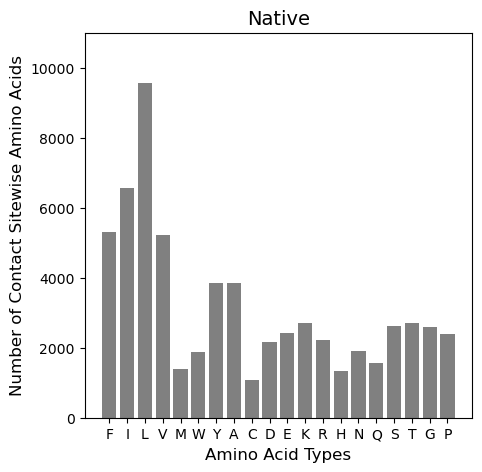

In [256]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    # sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,11000])

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot for result1
plot_sitewise_subplot(axs, np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")


# plt.savefig('figures/contact_pairs/native_3<d<5_sitwewise_counts.png', dpi=300)
# Show the plot
plt.show()

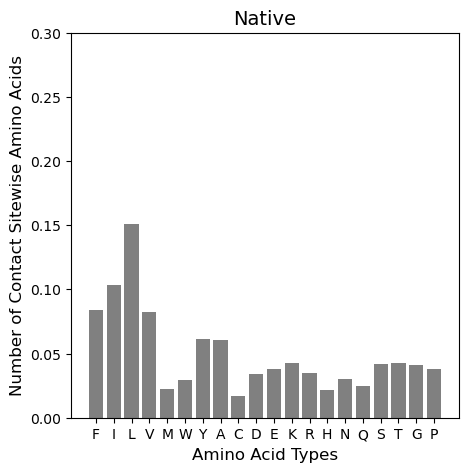

In [258]:
# Define the original and desired order
original_order = 'ACDEFGHIKLMNPQRSTVWY'
desired_order = 'FILVMWYACDEKRHNQSTGP'

# Create a mapping from the original order to the desired order
order_mapping = {desired_order[i]: original_order.index(desired_order[i]) for i in range(20)}


def plot_sitewise_subplot(ax, result_matrix, title):
    matrix = result_matrix[:20, :20]
    reordered_matrix = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            reordered_matrix[i, j] = matrix[order_mapping[desired_order[i]], order_mapping[desired_order[j]]]

    sitewise_matrix = np.zeros(20)
    for i in range(20):
        sitewise_matrix[i] = sum(reordered_matrix[:, i]) + sum(reordered_matrix[i, :])

    sitewise_matrix = sitewise_matrix/sum(sitewise_matrix)

    # Plotting the sitewise_matrix as a bar plot
    ax.bar(list(desired_order), sitewise_matrix, color='gray')  # Assuming the x-axis represents sites from 1 to 20
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Amino Acid Types', fontsize=12)
    ax.set_ylabel('Number of Contact Sitewise Amino Acids', fontsize=12)
    ax.set_ylim([0,0.3])

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot for result1
plot_sitewise_subplot(axs, np.array(np.sum(pairwise_count_native, axis=0)).reshape(21, 21), "Native")



# plt.savefig('figures/contact_pairs/native_3<d<5_sitwewise_prob.png', dpi=300)
# Show the plot
plt.show()